# Example 9: Travel Time compared to Fluid Age

This Example demonstrates how to create a matrix that depicts the travel times between all nodes in a network via a Python algorithm using dataframes provided by PT3S and compares theses results to the fluid age result that is calculated by SIR 3S.

Fluid age is a result calculated for each node in SIR 3S. 
It describes the amount of time water has spent in the network since leaving a source until reaching a node.

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Necessary packages for this Example

In [2]:
#pip install - q ...

# Imports

In [3]:
import os
import logging
import re
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from collections import deque
from matplotlib.collections import LineCollection
import networkx
from scipy.sparse import csc_matrix
from pandas import Timestamp
#...

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

try:
    from PT3S import Rm
except:
    import Rm

try:
    from PT3S import ncd
except:
    import ncd
#...

In [4]:
import importlib
from importlib import resources

In [5]:
#importlib.reload(dxAndMxHelperFcts)

# Logging

In [6]:
logger = logging.getLogger()  

logFileName= r"Example9.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Branched Network

In [7]:
dbFilename="Example9_1"

In [8]:
dbFile = resources.files("PT3S").joinpath("Examples", f"{dbFilename}.db3")

In [ ]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile
                                ,preventPklDump=True
                                ,maxRecords=-1
                                #,SirCalcExePath=r"C:\3S\SIR 3S\SirCalc-90-14-02-12_Potsdam.fix1_x64\SirCalc.exe"
                                ,crs="EPSG:25832" # random EPSG
                                )

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\PT3S\Examples\Example9_1.db3 exists readable ...
INFO    ; Dx.__init__:  SYSTEMKONFIG ID 3 not defined. Value(ID=3) is supposed to define the Model which is used in QGIS. Now QGISmodelXk is undefined ...
INFO    ; PT3S.dxAndMxHelperFcts.readDxAndMx:  QGISmodelXk not defined. Now the MX of 1st Model in VIEW_MODELLE is used ...
INFO    ; PT3S.dxAndMxHelperFcts.readDxAndMx: 
+..\PT3S\Examples\Example9_1.db3 is newer than
+..\PT3S\Examples\WDExample7_2\B1\V0\BZ1\M-1-0-1.1.MX1:
+SIR 3S' dbFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; PT3S.dxAndMxHelperFcts.readDxAndMx: Model is being recalculated using C:\3S\SIR 3S\SirCalc-90-14-02-12_Potsdam.fix1_x64\SirCalc.exe
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\PT3S\Examples\WDExample7_2\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example9_1: processing dx and mx ...


## SIR 3S results

### Preparing Data

In [10]:
dfKNOT=m.V3_KNOT

In [11]:
dfROHR=m.gdf_ROHR

In [12]:
dfROHR=dfROHR.rename(columns={'fkKI': 'tki', 'fkKK': 'tkk'})

#### Fluid age

In [13]:
# Build lookup Series from dfKNOT
lookup_TTR = dfKNOT.set_index('pk')['TTR']

In [14]:
# Map fkKI and fkKK to TTR
dfROHR['TTR_KI'] = dfROHR['tki'].map(lookup_TTR)
dfROHR['TTR_KK'] = dfROHR['tkk'].map(lookup_TTR)

#### Node coords

In [15]:
lookup_XKOR = dfKNOT.set_index('pk')['XKOR']
lookup_YKOR = dfKNOT.set_index('pk')['YKOR']

In [16]:
# Map fkKI and fkKK to XKOR
dfROHR['XKOR_KI'] = dfROHR['tki'].map(lookup_XKOR)
dfROHR['XKOR_KK'] = dfROHR['tkk'].map(lookup_XKOR)

In [17]:
# Map fkKI and fkKK to YKOR
dfROHR['YKOR_KI'] = dfROHR['tki'].map(lookup_YKOR)
dfROHR['YKOR_KK'] = dfROHR['tkk'].map(lookup_YKOR)

#### dt

In [18]:
dt=('STAT',
  'ROHR~*~*~*~DTTR',
  Timestamp('2025-06-05 13:27:46'),
  Timestamp('2025-06-05 13:27:46'))

In [19]:
dfROHR=dfROHR.rename(columns={dt: 'dt'})

In [20]:
#dfROHR['dt']=dfROHR['dt']*3600

#### v

In [21]:
v=('STAT',
  'ROHR~*~*~*~VAV',
  Timestamp('2025-06-05 13:27:46'),
  Timestamp('2025-06-05 13:27:46'))

In [22]:
dfROHR=dfROHR.rename(columns={v:'v'})

In [23]:
dfROHR['dt']=dfROHR['L']/dfROHR['v']

#### KVR

In [24]:
dfROHR['KVR_KI'] = 1
dfROHR['KVR_KK'] = 1

### Plotting

In [25]:
ax, nodes = ncd.plot_ttr_network(
    dfROHR,
    dn_col="DN",
    fk_ki_col='tki',
    fk_kk_col='tkk',
    geometry_col="geometry",
    dt_col='dt',
    show_edge_dt=True,
    ttr_norm="percentile", ttr_percentiles=(5, 95),
    linewidth_range=(7, 15),
    node_size=200,
    highlight_keys=[5136506604482101815], # source tk                 
    highlight_marker_size=250,
    show_values=True,
    annotation_fmt="{:.2f}"
)
plt.show()

The network has a constant pressure of 100 bar on the left-most node. And equal constant negative volume flow on all right-most nodes. Simulating a source on the left and consumers on the right.

What we can obeserve already here is that the fluid age in the upper branch is lower due to the lower diameter of the upper pipes that leads to a higher velocity and therefore a lower fluid age.

## Comparision: Travel Time Matrix

### Preparing Data

### Algorithm Implmentation

In [26]:
TMAX_DETECT = 1.0e12

In [27]:
def setup_graph(df_data_results_edges):
    """Setup graph from edges data and results.

    Parameters
    ----------
    df_data_results_edges: pandas.DataFrame
        Edges data and results.

    Returns
    -------
    G : networkx.Graph
        Graph.
    """

    # Nodes: index mapping (here via tk of nodes, alternatively via names of nodes)
    list_nodes_tk = sorted(list(set(list(df_data_results_edges["tki"]) + list(df_data_results_edges["tkk"]))))
    map_nodes_tk_ind = {list_nodes_tk[ii]: ii for ii in range(len(list_nodes_tk))}

    # Adapt DataFrame
    df_data_results_edges["indi"] = df_data_results_edges["tki"].apply(lambda x: map_nodes_tk_ind[x])
    df_data_results_edges["indk"] = df_data_results_edges["tkk"].apply(lambda x: map_nodes_tk_ind[x])

    df_data_results_edges["indi_new"] = df_data_results_edges[["indi", "indk"]].min(axis=1)
    df_data_results_edges["indk_new"] = df_data_results_edges[["indi", "indk"]].max(axis=1)
    df_data_results_edges["dt_new"] = np.sign(df_data_results_edges["indk"] - df_data_results_edges["indi"])*df_data_results_edges["dt"]

    # Setup graph
    G = networkx.Graph()
    for _, row in df_data_results_edges.iterrows():
        G.add_edge(
            row['indi_new'],  # Start node
            row['indk_new'],  # End node
            # Additional edge attributes
            dt=row['dt_new']
        )

    # Out
    return G, map_nodes_tk_ind

In [28]:
def bfs_observedNodes(G, source, tmax):
    """Breadth-first-search starting at source.

    Parameters
    ----------
    G : networkx.Graph
        Graph.
    source : int
        Source node.
    tmax : float
        Maximum travel time.
    """

    visited = set([source])
    neighbors = G.neighbors
    queue = deque([(source, neighbors(source))])

    dt_travel_sum = {source: 0.0}

    while queue:
        parent, children = queue[0]

        try:
            child = next(children)

            edge = (min(parent, child), max(parent, child))
            sign_dt = np.sign(child - parent)

            dt_travel = sign_dt*G[edge[0]][edge[1]]['dt']
            dt_travel_sum[child] = dt_travel_sum[parent] + np.abs(dt_travel)

            if ((child not in visited) and (dt_travel_sum[child] < tmax) and dt_travel < 0.0):
                yield parent, child
                visited.add(child)
                queue.append((child, neighbors(child)))

        except StopIteration:
            queue.popleft()

In [29]:
def setup_travelTimeMatrix(df_data_results_edges):
    """Setup travel time matrix from edges data and results.

    Parameters
    ----------
    df_data_results_edges: pandas.DataFrame
        Edges data and results.

    Returns
    -------
    TMat : numpy.ndarray
        Travel time matrix.
    map_nodes_tk_ind : dict
        Mapping nodes tk to index.
    """

    # Setup graph
    G, map_nodes_tk_ind = setup_graph(df_data_results_edges)

    # Find sets of observed nodes by bfs search and setup matrix V
    obsNodes = {}
    obsNodesL = {}

    travelTimesAccObsNodesDict = {}

    for iSens in G.nodes:

        bfs_edges = list(bfs_observedNodes(G, iSens, TMAX_DETECT))

        nodesSet = set()
        endNodeLDict = {}

        for (lli, llk) in bfs_edges:
            nodesSet.add(lli)
            nodesSet.add(llk)
            edgex = (min(lli, llk), max(lli, llk))
            endNodeLDict[llk] = G[edgex[0]][edgex[1]]['dt']

        if (len(nodesSet) > 0):
            obsNodes[iSens] = nodesSet - {iSens}
            obsNodesL[iSens] = endNodeLDict

        # Calculate travel time matrix data
        edgesListUse = []
        for edgex in bfs_edges:
            (ix, kx) = edgex
            ix_new, kx_new = min(ix, kx), max(ix, kx)
            weight = abs(G[ix_new][kx_new]['dt'])
            edgesListUse.append((ix_new, kx_new, weight))

        Gtrav = networkx.Graph()
        if (len(edgesListUse) > 0):
            Gtrav.add_weighted_edges_from(edgesListUse)
            travelTimesAccObsNodesDict[iSens] = networkx.single_source_dijkstra_path_length(
                Gtrav, source=iSens, cutoff=None, weight='weight')
            

    # Setup travel time matrix
    rowsTTrav = []
    columnsTTrav = []
    dataTTrav = []

    for iSens in obsNodes.keys():
        # travel time from node to sensor
        ttravs = travelTimesAccObsNodesDict[iSens]
        for iObserved in ttravs:
            rowsTTrav.append(iSens)
            columnsTTrav.append(iObserved)
            dataTTrav.append(ttravs[iObserved])

    TMatSparse = csc_matrix((dataTTrav, (rowsTTrav, columnsTTrav)), shape=(len(G.nodes), len(G.nodes)))

    # Trafo to dense matrices
    TMat = 1.0*TMatSparse.toarray()

    # Out
    return TMat, map_nodes_tk_ind

### Calculation

In [30]:
TMat, map_nodes_tk_ind = setup_travelTimeMatrix(dfROHR)

In [31]:
TMat=TMat/3600

In [32]:
np.set_printoptions(linewidth=200)
TMat.round(2)

array([[0.  , 0.  , 1.53, 0.74, 0.  , 0.  , 0.  , 0.  , 0.49],
       [0.  , 0.  , 1.59, 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.53, 0.74, 0.  , 0.  , 0.  , 0.  , 0.49],
       [0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.59, 3.18, 0.  , 0.  , 2.39, 0.  , 0.  , 0.  ],
       [0.  , 1.59, 3.18, 0.  , 0.  , 2.39, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.04, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ]])

This travel time matrix differs to the fluid age calculated by SIR 3S already in the sense that we can only consider one source at a time. In our given example model this is the case. If we had two sources we would need to consider them (two differnt cols) seperatley.

### Plotting

In [33]:
# Choose a source by tk (preferred)
source_tk = "5136506604482101815"

ax, nodes_tt = ncd.plot_travel_time_from_source(
    dfROHR,
    TMat=TMat,
    map_nodes_tk_ind=map_nodes_tk_ind,
    source=source_tk,                         # or pass an integer matrix index
    cmap="viridis",
    linewidth_range=(7, 15),
    node_size=200,
    ttr_norm="percentile", ttr_percentiles=(5, 95),
    treat_zero_as_unreachable=True,           # hides unreachable nodes; source remains at 0.0
    highlight_keys=[source_tk],               # star the source (and any others you pass)
    highlight_match="both",
    colorbar_label="Travel time [h]",
    show_axis=False,
    show_values=True,
    dt_col='dt',
    show_edge_dt=True,
    annotation_fmt="{:.2f}"
)

plt.show()


If we compare this plot to the first one, that used the fluid age calculated by SIR 3S directley, we observe that they are identical.

# Meshed Network

The model 9_2 differs to 9_1 only in that the upper and lower branch are connected via a pipe.

## Read Model and Results

In [34]:
dbFilename="Example9_2"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [57]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile
                                ,preventPklDump=True
                                ,maxRecords=-1
                                #,SirCalcExePath=r"C:\3S\SIR 3S\SirCalc-90-14-02-12_Potsdam.fix1_x64\SirCalc.exe"
                                ,crs="EPSG:25832" # random EPSG
                                )

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\PT3S\Examples\Example9_2.db3 exists readable ...
INFO    ; Dx.__init__:  SYSTEMKONFIG ID 3 not defined. Value(ID=3) is supposed to define the Model which is used in QGIS. Now QGISmodelXk is undefined ...
INFO    ; PT3S.dxAndMxHelperFcts.readDxAndMx:  QGISmodelXk not defined. Now the MX of 1st Model in VIEW_MODELLE is used ...
INFO    ; PT3S.dxAndMxHelperFcts.readDxAndMx: Model is being recalculated using C:\3S\SIR 3S\SirCalc-90-14-02-12_Potsdam.fix1_x64\SirCalc.exe
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\PT3S\Examples\WDExample9_2\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example9_2: processing dx and mx ...


## SIR 3S results

### Preparing Data

In [58]:
dfKNOT=m.V3_KNOT

In [59]:
dfROHR=m.gdf_ROHR

#### TTR

In [60]:
# Build lookup Series from dfKNOT
lookup_TTR = dfKNOT.set_index('pk')['TTR']


In [61]:
# Map fkKI and fkKK to TTR
dfROHR['TTR_KI'] = dfROHR['fkKI'].map(lookup_TTR)
dfROHR['TTR_KK'] = dfROHR['fkKK'].map(lookup_TTR)

#### Node coords

In [62]:
lookup_XKOR = dfKNOT.set_index('pk')['XKOR']
lookup_YKOR = dfKNOT.set_index('pk')['YKOR']

In [63]:
# Map fkKI and fkKK to XKOR
dfROHR['XKOR_KI'] = dfROHR['fkKI'].map(lookup_XKOR)
dfROHR['XKOR_KK'] = dfROHR['fkKK'].map(lookup_XKOR)

In [64]:
# Map fkKI and fkKK to YKOR
dfROHR['YKOR_KI'] = dfROHR['fkKI'].map(lookup_YKOR)
dfROHR['YKOR_KK'] = dfROHR['fkKK'].map(lookup_YKOR)

#### KVR

In [65]:
dfROHR['KVR_KI'] = 1
dfROHR['KVR_KK'] = 1

#### dt

In [66]:
dt_abs=('STAT',
  'ROHR~*~*~*~DTTR',
  Timestamp('2025-06-05 13:27:46'),
  Timestamp('2025-06-05 13:27:46'))

In [67]:
dfROHR=dfROHR.rename(columns={dt_abs: 'dt_abs'})

In [68]:
dfROHR['dt_abs']=dfROHR['dt_abs']*3600

#### v

In [69]:
v=('STAT',
  'ROHR~*~*~*~VAV',
  Timestamp('2025-06-05 13:27:46'),
  Timestamp('2025-06-05 13:27:46'))

In [70]:
dfROHR=dfROHR.rename(columns={v:'v'})

In [71]:
dfROHR['dt']=dfROHR['L']/dfROHR['v']

### Plotting

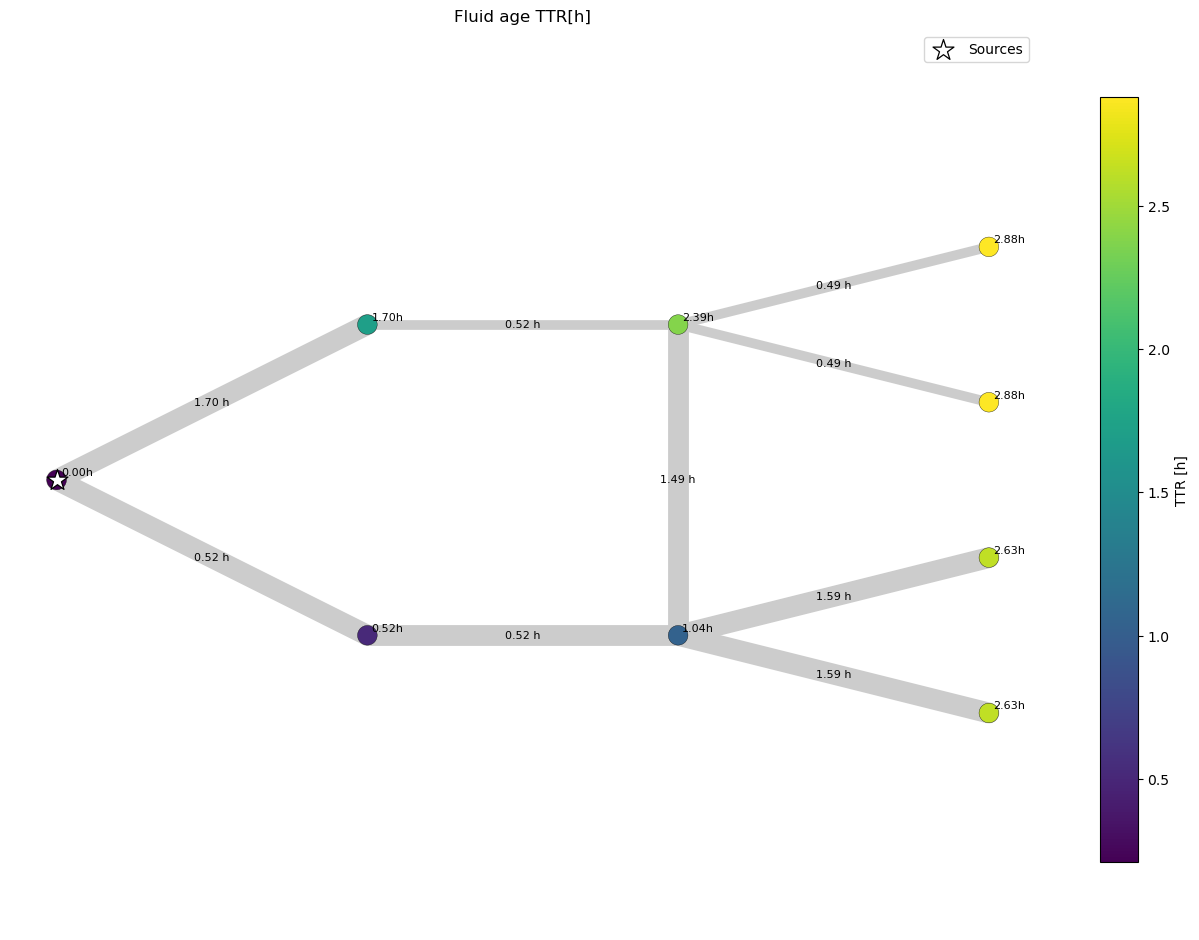

In [72]:
ax, nodes = ncd.plot_ttr_network(
    dfROHR,
    dn_col="DN",
    fk_ki_col='fkKI',
    fk_kk_col='fkKK',
    geometry_col="geometry",
    ttr_norm="percentile", ttr_percentiles=(5, 95),
    linewidth_range=(7, 15),
    node_size=200,
    highlight_keys=[5136506604482101815], # source tk                 
    highlight_marker_size=250,
    show_values=True,
    dt_col='dt',
    show_edge_dt=True,
    annotation_fmt="{:.2f}"
)
plt.show()

We can observe that due to the inserted connection between the upper and lower branch the travel time in the upper branch changes, because water flows from the lower to the upper branch.

Why does the node in the upper branch that is connected to the lower branch have a water age of 2.39 h?
This node receives water from two pipes, therefore its water age is the water age coming from both pipes weighted by the volume flow.

Example Calculation:

In [73]:
dfROHR['QMAVAbs']

0     93.552284
1    100.000000
2    100.000000
3    306.447723
4    306.447723
5    100.000000
6    100.000000
7     93.552284
8    106.447716
Name: QMAVAbs, dtype: float64

The pipe reaching the node from the left has a volume flow of 94 m^3/h
The pipe reaching the node from the bottom has a volume flow of 106 m^3/h

Fluid age = (94^3/h * (1.70h+0.52h) + 106^3/h * (1.04h+1.49h)) / (94^3/h + 106^3/h) = 2.39h (approx due to rounding error)

This approach also works for nodes not supplied 100% by one source.

## Comparision: Travel Time Matrix

### Preparing Data

In [74]:
dfROHR=dfROHR.rename(columns={'fkKI': 'tki', 'fkKK': 'tkk'})

### Algorithm Implmentation

We reuse the algorithm already implemented

### Calculation

In [75]:
TMat, map_nodes_tk_ind = setup_travelTimeMatrix(dfROHR)

In [76]:
TMat=TMat/3600

In [77]:
np.set_printoptions(linewidth=200)
TMat.round(2)

array([[0.  , 1.98, 2.72, 1.02, 0.  , 2.5 , 0.  , 0.  , 0.49],
       [0.  , 0.  , 1.04, 0.  , 0.  , 0.52, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.7 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.98, 2.72, 1.02, 0.  , 2.5 , 0.  , 0.  , 0.49],
       [0.  , 0.  , 0.52, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.59, 2.63, 0.  , 0.  , 2.11, 0.  , 0.  , 0.  ],
       [0.  , 1.59, 2.63, 0.  , 0.  , 2.11, 0.  , 0.  , 0.  ],
       [0.  , 1.49, 2.22, 0.52, 0.  , 2.01, 0.  , 0.  , 0.  ]])

### Plotting

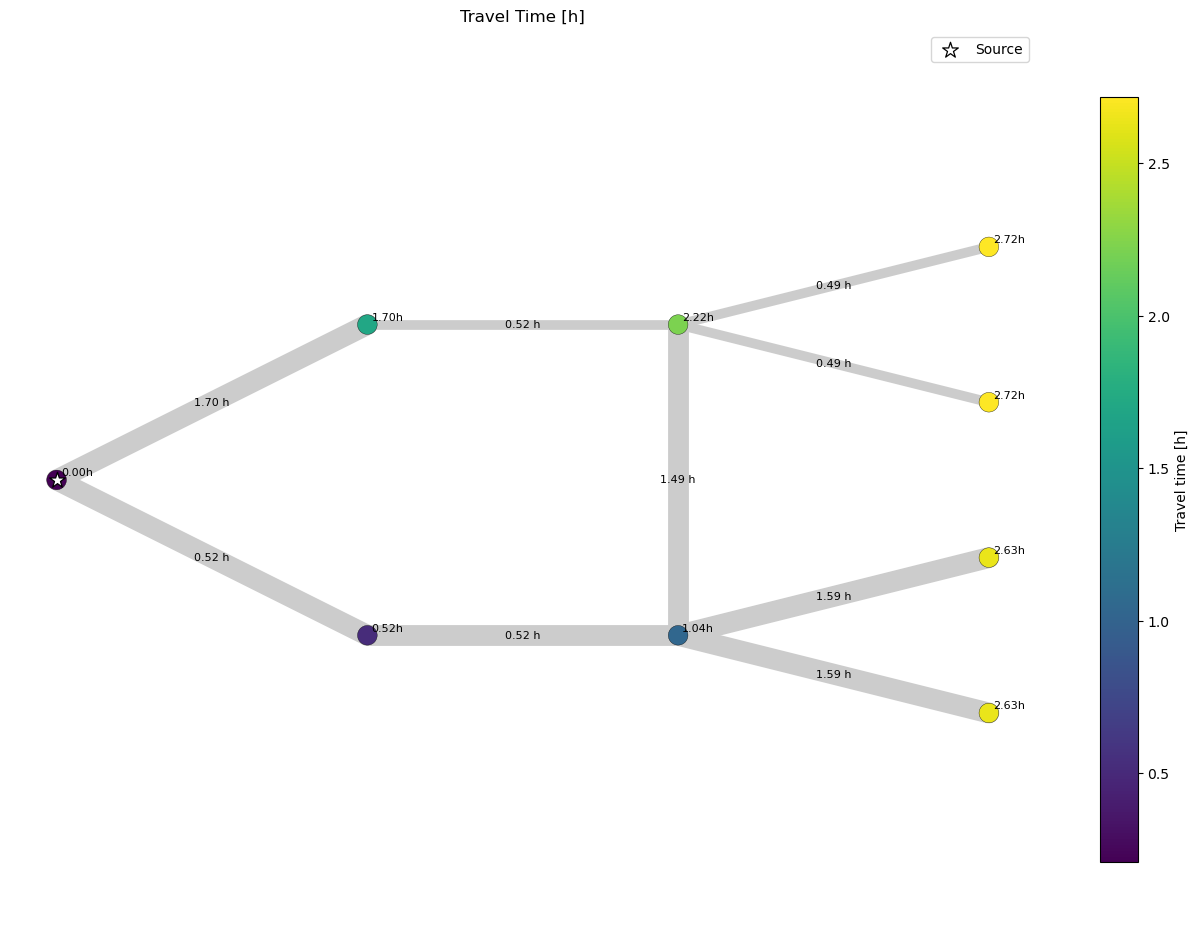

In [78]:
# Choose a source by tk (preferred)
source_tk = "5136506604482101815"

ax, nodes_tt = ncd.plot_travel_time_from_source(
    dfROHR,
    TMat=TMat,
    map_nodes_tk_ind=map_nodes_tk_ind,
    source=source_tk,                         # or pass an integer matrix index
    cmap="viridis",
    linewidth_range=(7, 15),
    node_size=200,
    ttr_norm="percentile", ttr_percentiles=(5, 95),
    treat_zero_as_unreachable=True,           # hides unreachable nodes; source remains at 0.0
    highlight_keys=[source_tk],               # star the source (and any others you pass)
    highlight_match="both",
    colorbar_label="Travel time [h]",
    show_axis=False,
    show_values=True,
    dt_col='dt',
    show_edge_dt=True,
    annotation_fmt="{:.2f}"
)

plt.show()


If we compare this plot to the previous one, that used the fluid age calculated by SIR 3S directley, we observe that they the travel time values do not equal the fluid age. The reason for that is that the travel time algorithm uses a Dijkstra algorithm on a graph that has edges that are weighted by the time spent in each pipe. If we now consider the node connected to four pipes in the upper branch. We see that the travel time is lower than the fluid age calculated. As the travel time algorithm does not consider flow this is not unexpected. The travel time algorithm only considers the upper branch for the calculation of the travel time and not the contribution of the lower branch.